In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [3]:
from scipy.spatial.distance import pdist, squareform
def VAT(R):
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)
    
    I = i[j]
    del J[I]
    
    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    C = [1,1]

    for r in range(2, N-1):
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)
        y = np.min(y)
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])

    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)

    I.extend(J)
    C.extend(i)

    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    return RV.tolist(), C, I


def entropy(probs):
    
    return -probs.dot(np.log2(probs))


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 


In [4]:
traffic = pd.read_csv("Traffic_Volume.csv", header=0,low_memory=False)
print(traffic.shape[0])

14674


([<matplotlib.patches.Wedge at 0x1a27499e48>,
 [Text(5.599999978388097, 0.000491989132689295, 'Forest roads'),
  Text(-0.5714767360013756, 5.570764250999069, 'Freeway & State Highways'),
  Text(-4.661924327526211, -3.1026539549906755, 'Local Roads'),
  Text(2.4718349307713527, -5.024941002143068, 'Main Roads'),
  Text(5.593627317031727, -0.26708320455702284, 'Ramps'),
  Text(5.598903119457783, -0.11083257159296943, 'Tourist roads')],
 [Text(4.599999982247366, 0.00040413393042334936, '    0%'),
  Text(-0.4694273188582728, 4.575984920463521, '   53%'),
  Text(-3.829437840467959, -2.5486086058851973, '   12%'),
  Text(2.0304358359907537, -4.127630108903235, '   34%'),
  Text(4.594765296133204, -0.21938977517184016, '    0%'),
  Text(4.599098990983179, -0.09104104095136775, '    1%')])

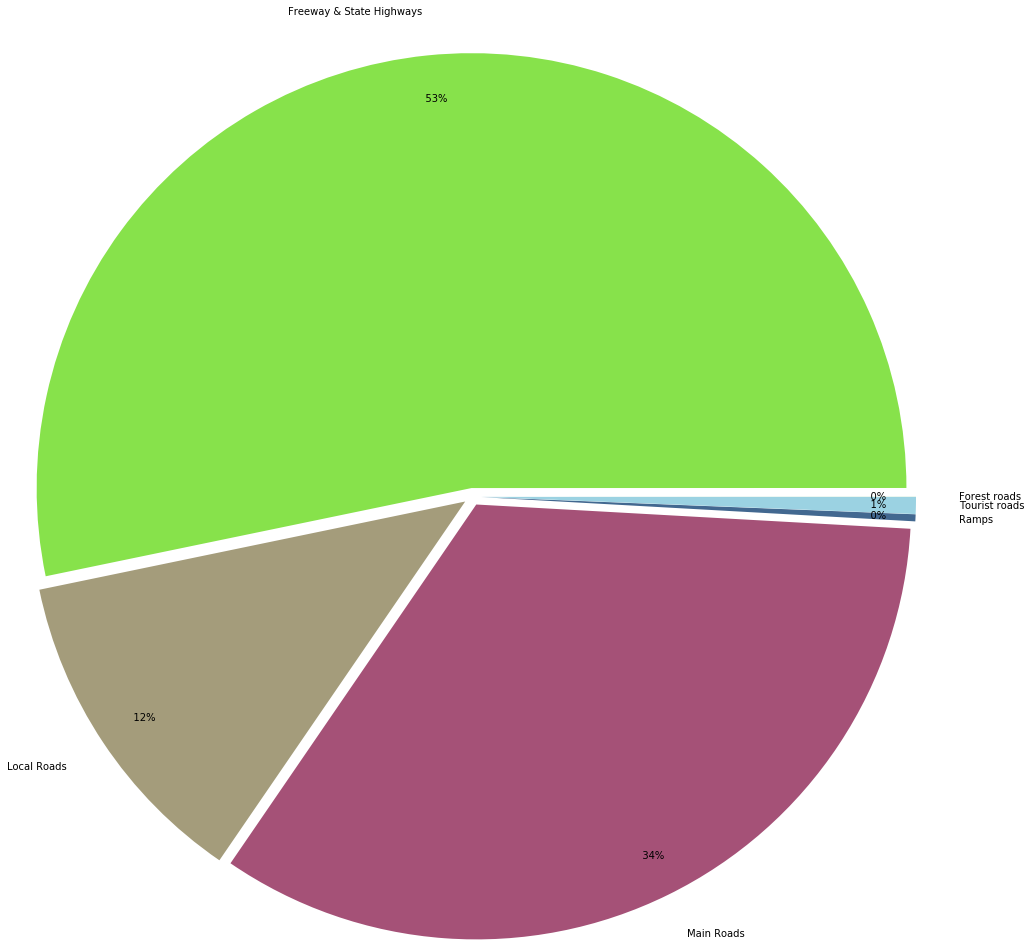

In [5]:
traffic["ROAD_NBR"] = traffic["ROAD_NBR"].astype(int)
traffic["ROAD_CLASSIFICATION"] = np.where(traffic["ROAD_NBR"] <= 2999, 'Freeway & State Highways',(np.where(traffic["ROAD_NBR"] <= 3999, 'Forest roads', (np.where(traffic["ROAD_NBR"] <= 4999, 'Tourist roads', (np.where(traffic["ROAD_NBR"] <= 5999, 'Main Roads', (np.where(traffic["ROAD_NBR"] <= 7999, 'Ramps', 'Local Roads')))))))))
piec = traffic.groupby(["ROAD_CLASSIFICATION"]).sum()
sizes = piec.loc[:,"ALLVEHS_AADT"]
colour = []
for i in range(6):
    colour.append((np.random.random()*0.7 + 0.2, np.random.random()*0.7+0.2,np.random.random()*0.7+0.2))
#plt.title("Sum of ALLVEHS_AADT in percentage in each road classification")
plt.pie(sizes, explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1), labels = piec.index.values ,radius = 5 ,autopct='%5.0f%%',pctdistance = 0.9, colors = colour)
#plt.ylabel("SUM ALLVEHS_AADT")

In [6]:
crash = pd.read_csv("ACCIDENT/ACCIDENT_LOCATION.csv", header=0,low_memory=False)
print(crash.shape[0])

176937


                          ACCIDENT_NO  NODE_ID  ROAD_ROUTE_1  ROAD_NAME  \
ROAD_CLASSIFICATION                                                       
Forest roads                       90       90            90         90   
Freeway & State Highways        42676    42676         42676      42540   
Local Roads                     65765    65765         64940      64940   
Main Roads                      63695    63695         63695      63695   
Ramps                            1924     1924          1924       1924   
Tourist roads                    2787     2787          2787       2787   

                          ROAD_TYPE  ROAD_NAME_INT  ROAD_TYPE_INT  \
ROAD_CLASSIFICATION                                                 
Forest roads                     90             90             90   
Freeway & State Highways      41585          42223          41879   
Local Roads                   64306          64927          64489   
Main Roads                    63384          63652    

([<matplotlib.patches.Wedge at 0x1a28e61198>,
 [Text(5.599992850010934, 0.008948733230282684, 'Forest roads'),
  Text(4.055504622570639, 3.8617201162575445, 'Freeway & State Highways'),
  Text(-5.029648280316617, 2.4622425096460545, 'Local Roads'),
  Text(1.5075757643279204, -5.393256466626735, 'Main Roads'),
  Text(5.550447134006247, -0.7433280652590963, 'Ramps'),
  Text(5.59314506994793, -0.27699860381809116, 'Tourist roads')],
 [Text(4.599994126794695, 0.00735074515344649, '    0%'),
  Text(3.3313073685401675, 3.1721272383544115, '   24%'),
  Text(-4.131496801688649, 2.022556347209259, '   37%'),
  Text(1.2383658064122203, -4.430174954729104, '   36%'),
  Text(4.55929586007656, -0.6105909107485434, '    1%'),
  Text(4.594369164600085, -0.22753456742200343, '    2%')])

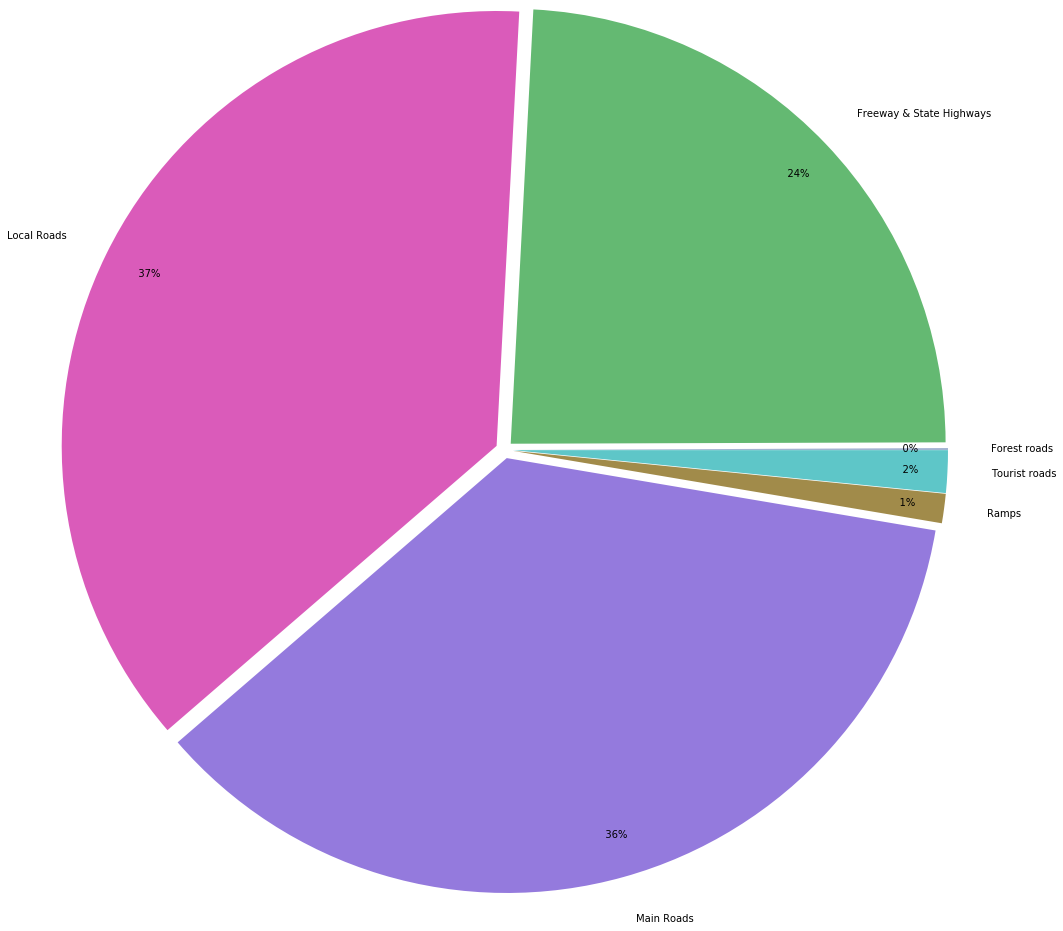

In [7]:
crash["ROAD_CLASSIFICATION"] = np.where(crash["ROAD_ROUTE_1"] <= 2999, 'Freeway & State Highways',(np.where(crash["ROAD_ROUTE_1"] <= 3999, 'Forest roads', (np.where(crash["ROAD_ROUTE_1"] <= 4999, 'Tourist roads', (np.where(crash["ROAD_ROUTE_1"] <= 5999, 'Main Roads', (np.where(crash["ROAD_ROUTE_1"] <= 7999, 'Ramps', 'Local Roads')))))))))
piec = crash.groupby(["ROAD_CLASSIFICATION"]).count()
sizes = piec.loc[:,"ACCIDENT_NO"]
print(piec)
colour = []
for i in range(6):
    colour.append((np.random.random()*0.7 + 0.2, np.random.random()*0.7+0.2,np.random.random()*0.7+0.2))
plt.pie(sizes, explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1), labels = piec.index.values ,radius = 5 ,autopct='%5.0f%%',pctdistance = 0.9, colors = colour)


In [69]:
rdnmbr = crash.groupby(["ROAD_NAME"]).count()
rdnmbr = rdnmbr.sort_values(by = "ACCIDENT_NO", ascending = False)

print("--- Top 10 Road Accident ---")
j=1
for i in rdnmbr.index.values[0:10]:
    print(str(j) + ":" + " " + i + " " + str(rdnmbr.loc[i,"ACCIDENT_NO"]) + " accidents")
    j+=1

--- Top 10 Road Accident ---
1: PRINCES 4438 accidents
2: HIGH 2730 accidents
3: NEPEAN 2107 accidents
4: SPRINGVALE 1447 accidents
5: SOUTH GIPPSLAND 1409 accidents
6: MONASH 1398 accidents
7: SYDNEY 1381 accidents
8: BURWOOD 1339 accidents
9: DANDENONG 1248 accidents
10: MAROONDAH 1172 accidents


0.0


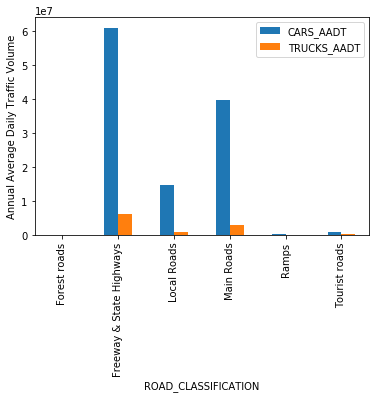

In [17]:
traffic["CARS_AADT"] = (traffic["ALLVEHS_AADT"]*365 - traffic["TRUCKS_AADT"]*365 - traffic["BUSES_AADT"]*365 - traffic["MOTORCYCLES_AADT"]*365 - traffic["TRAMS_AADT"]*365)/365
traffic["CARS_ADT"] = traffic["CARS_AADT"]*365
traffic["TRUCKS_ADT"] = traffic["TRUCKS_AADT"]*365
traffic["TrafficLevel"] = np.where(traffic["ALLVEHS_AADT"] > traffic["ALLVEHS_AADT"].quantile(0.8), "1", "0")
traffic_high=traffic.loc[traffic['TrafficLevel']== "1"]
traffic_low=traffic.loc[traffic["TrafficLevel"] == "0"]
traffic = traffic.fillna(0)
bygroupsum = traffic.groupby("ROAD_CLASSIFICATION").sum()
bygroupsum["TRUCKS_AADT"] = bygroupsum["TRUCKS_ADT"]/365
bygroupsum["CARS_AADT"] = bygroupsum["CARS_ADT"]/365
bygroupsum[["CARS_AADT", "TRUCKS_AADT"]].plot(kind="bar")
plt.ylabel("Annual Average Daily Traffic Volume")


traffic["Norm TRUCK_AADT"] = (traffic["TRUCKS_AADT"] - traffic["TRUCKS_AADT"].min())/(traffic["TRUCKS_AADT"].max() - traffic["TRUCKS_AADT"].min())
traffic["Norm CAR_AADT"] = (traffic["CARS_AADT"] - traffic["CARS_AADT"].min())/(traffic["CARS_AADT"].max() - traffic["CARS_AADT"].min())
traffic["Norm BUSES_AADT"] = (traffic["BUSES_AADT"] - traffic["BUSES_AADT"].min())/(traffic["BUSES_AADT"].max() - traffic["BUSES_AADT"].min())
traffic["Norm MOTORCYCLES_AADT"] = (traffic["MOTORCYCLES_AADT"] - traffic["MOTORCYCLES_AADT"].min())/(traffic["MOTORCYCLES_AADT"].max() - traffic["MOTORCYCLES_AADT"].min())
traffic["Norm TRAMS_AADT"] = (traffic["TRAMS_AADT"] - traffic["TRAMS_AADT"].min())/(traffic["TRAMS_AADT"].max() - traffic["TRAMS_AADT"].min())

pc = traffic["Norm TRUCK_AADT"].to_frame()
pc["Norm TRUCK_AADT"] = traffic["Norm TRUCK_AADT"]
pc["Norm CAR_AADT"] = traffic["Norm CAR_AADT"]
pc["Norm BUSES_AADT"] = traffic["Norm BUSES_AADT"]
pc["Norm MOTORCYCLES_AADT"] = traffic["Norm MOTORCYCLES_AADT"]
pc["Norm TRAMS_AADT"] = traffic["Norm TRAMS_AADT"]
pc = pc.fillna(0)
print(traffic["MOTORCYCLES_AADT"].max())
#pd.plotting.parallel_coordinates(pc, "YR")
